# Train notebook for focusfinder

Last tutorial on this page should be exactly whats needed

https://docs.fast.ai/tutorial.vision

In [1]:
from fastai.vision.all import *

### All current imgs (244px)

In [2]:
path = Path('../')
labels_path = path/'download/labels/train_labels.csv'
images_path = path/'download/images/norm_images'

### load labels csv

In [3]:
df = pd.read_csv(labels_path)

In [4]:
df.head()

,Unnamed: 0,name,x_p,y_p
0,0,-0_ww2ACIw8.jpg,105.634146,162.666667
1,1,-0YZgPxq04k.jpg,126.463415,102.162602
2,2,-1qb8SIBzKY.jpg,104.642276,95.219512
3,3,-2loC3xzDF8.jpg,115.552846,156.715447
4,4,-3cTY-Q6k88.jpg,150.268293,108.113821


### define label function
Function is needed that takes the file_name as input and returns the focus point of the corresponing image

In [4]:
import re

def get_focus_point(path_name):
    dfb = next(iter(df[df['name']==path_name.name].index), ('no match for '+path_name.name))
    return tensor([float(df['x_p'][dfb]), float(df['y_p'][dfb])])

In [28]:
# check if there are matches for each file
img_files = get_image_files(images_path)
for __img in img_files:
    get_focus_point(__img)

### create datablock and dataloader

In [5]:
imgs = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_focus_point,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)],
    item_tfms=Resize(244),
)

In [6]:
dls = imgs.dataloaders(images_path, bs=16)

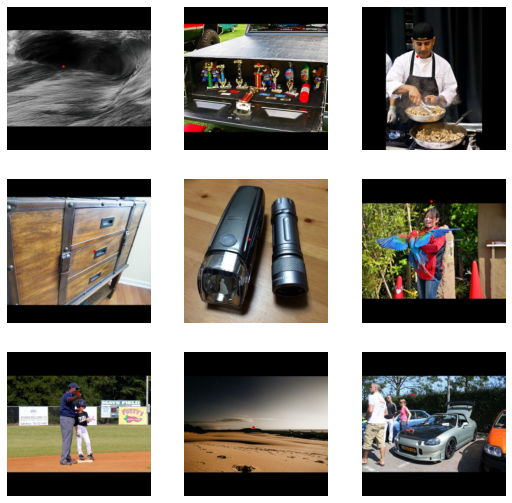

In [38]:
dls.show_batch()

### create model and train

In [7]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1), metrics=mse)
# try other models

In [8]:
# only helper for vscode, so that the output bars from fastai do not get removed when the cell is done
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0691830962896347)

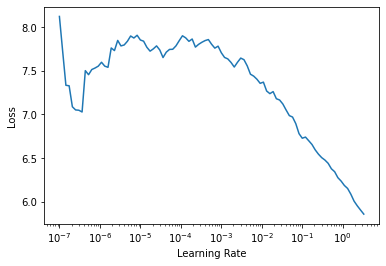

In [9]:
learn.lr_find()

In [94]:
learn.fine_tune(1, 2e-5) # 5e-3
# RETRAIN LATER

epoch,train_loss,valid_loss,time
0,0.417985,0.237045,19:02


### test model

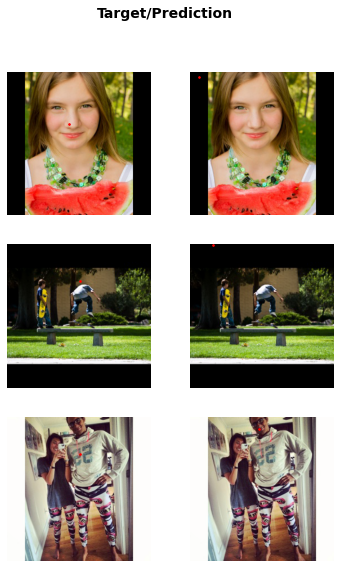

In [14]:
learn.show_results()

In [15]:
preds, y = learn.get_preds()

distances = []
for _p, _y in zip(preds, y):
    d = np.linalg.norm(_p-_y[0])
    distances.append(d)

mean = np.mean(distances)
print('The mean is {:.2f} or {:.2f} px'.format(mean, (mean*256)))
# std_dev = 

### export model

In [13]:
learn.export('./models/focusfinder_4000_2e-5.pkl')

## load trained model
---

In [7]:
# if model is already trained
model = load_learner('models/2020116165217-100epochs-4e-05trainrate_model.pkl')

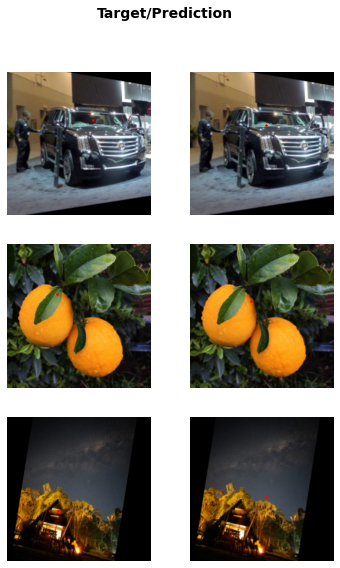

In [14]:
model.show_results(dl=dls)

In [15]:
preds, y = model.get_preds(dl=dls)

distances = []
for _p, _y in zip(preds, y):
    d = np.linalg.norm(_p-_y[0])
    distances.append(d)

mean = np.mean(distances)
print('The mean is {:.2f} or {:.2f} px'.format(mean, (mean*244)))
# std_dev = 

IndexError: index 5516 is out of bounds for dimension 0 with size 5504

# Summary

- learn_rate: 5e-3 ~5 epochs (focusfinder_4000_5e-3.pkl)
    - The mean is 0.23 or 59.97 px
- learn_rate: 2e-5 ~10 epochs (focusfinder_4000_2e-5.pkl))
    - The mean is 0.63 or 161.16 px
- 2020115221815-30epochs-0.0002trainrate_model.pkl
    - The mean is 0.28 or 70.99 px